# Problem Statement
With increasing number of mass shooting incidents at schools, malls and other public places across US of A, there is a need of effective monitoring systems that can identify potential dangers and alert beforehand. Law enforcement agencies that guard public places currently rely on technology like walk-through or handheld magnetometers, which detect changes in local magnetic fields.

The requirement is to create an AI powered gun detection system that can identify threats by connecting with the existing video surveillance cameras to reliably and rapidly recognize firearms and immediately trigger multi-channel alerts and automate pre-defined safety protocols.

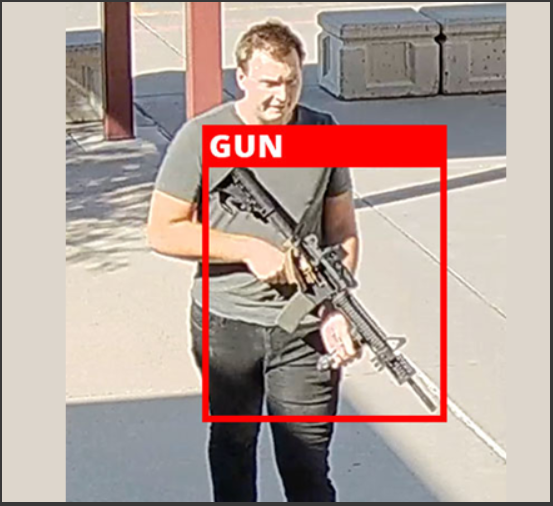

In [1]:
import os
import random
import glob
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# notebook configuration
pd.set_option("display.max_columns", None)
sns.set_theme(style = "whitegrid")
warnings.filterwarnings("ignore")
# plt.rcParams['figure.figsize'] = (20, 10)

# Introduction To Object Detection
In Image classification, CNNs were developed to detect objects present anywhere in an image and assign them with a probability scores and labels. The class labels and probability scores are generally associated with the full image and care about the presence or absence of the object of interest in the image. 

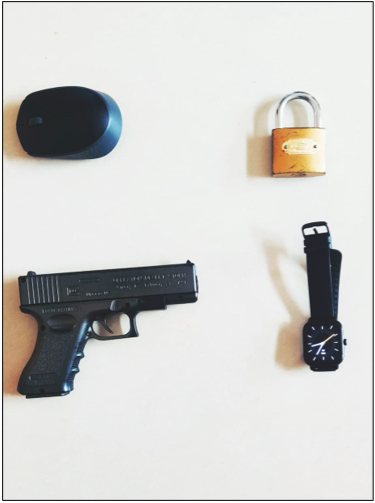

But what if there is need to find the location of the object of interest in the image or how many objects are present in the image?

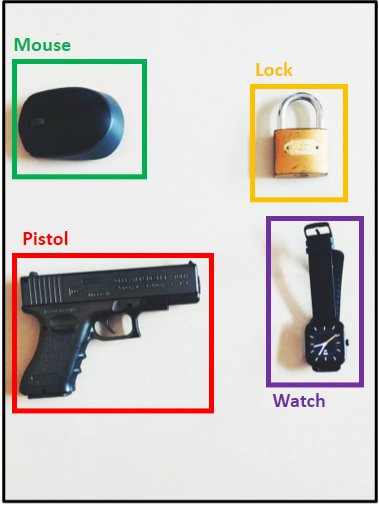

Object detection addresses these limitations by not only identifying the presence of objects but also pinpointing their exact locations within an image. This is typically achieved by drawing bounding boxes around the detected objects.

### Key differences from Image Classification
- Granularity: Image classification provides a label for the entire image, while object detection focuses on individual objects within the image.
- Output:
    - Image classification: Class label and probability score.
    - Object detection: Class label, probability score and bounding box coordinates.
- Spatial information: Object detection explicitly considers the spatial relationships between objects in the image.

### Applications of Object Detection
- Self-driving cars: Detecting pedestrians, vehicles and traffic signs.
- Surveillance systems: Identifying and tracking individuals or objects of interest.
- Medical image analysis: Detecting tumors or anomalies in medical images.
- Retail: Analyzing customer behavior and inventory management.
- Robotics: Enabling robots to interact with the environment.

In summary, object detection is a crucial task in Computer Vision that provides more detailed information about the content of an image compared to image classification. By combining object localization and classification, it enables a wide range of applications that require understanding the spatial arrangement of object in a scene.

# Loading And Exploring The Dataset

In [ ]:
datapath = "pistol_data"
!ls {datapath}

pistol_annotations pistol_images


In [4]:
annot_files = sorted(os.listdir(f"{datapath}/pistol_annotations"))
image_files = sorted(os.listdir(f"{datapath}/pistol_images"))

print(f"Total files: {len(annot_files)}")
print(f"Top 5: {annot_files[: 5]}")
print(f"Top 5: {image_files[: 5]}")

Total files: 3703
Top 5: ['1.txt', '10.txt', '100.txt', '1000.txt', '1001.txt']
Top 5: ['1.jpg', '10.jpg', '100.jpg', '1000.jpg', '1001.jpg']


In [ ]:
# content in each of the annotation files
for annot_file in annot_files[0: 5]:
    with open(f"{datapath}/pistol_annotations/{annot_file}", "r") as f:
        print(f.readlines())

['1 0.4253846153846154 0.2447973713033954 0.22153846153846152 0.2814895947426068']
['1 0.4983922829581993 0.4907407407407407 0.3665594855305466 0.4506172839506173']
['1 0.6466602129719264 0.28387096774193543 0.08131655372700872 0.05935483870967742']
['1 0.5747967479674796 0.39390243902439026 0.27804878048780485 0.3341463414634146']
['1 0.5061538461538462 0.4229559748427673 0.3353846153846154 0.3050314465408805']


Each `.txt` file inside pistol_annotations contains 4 point coordinated which represent the location of the Gun in the corresponding image as (`x_center`, `y_center`, `width`, `height`).

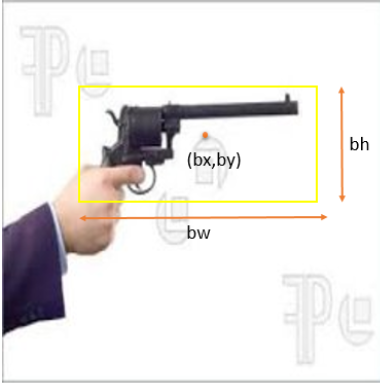